In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [ ]:
FILE_PATH = ''
NUM_BATCHES = 16

In [ ]:
with open(FILE_PATH) as f:
    data = f.read()
corpus = data.lower().split("\n")

In [ ]:
for i in range(5):
  print(corpus[i])

In [ ]:
vectorizer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    ragged=True
)
vectorizer.adapt(corpus)

In [ ]:
total_words = len(vectorizer.get_vocabulary())

In [ ]:
total_words

In [ ]:
def generate_n_grams(corpus, vectorizer):
    input_sequences = []
    whole_corpus = vectorizer(corpus)
    for line in whole_corpus:
        for i in range(2, len(line) + 1):
            n_gram_seq = line[:i]
            input_sequences.append(n_gram_seq)
    
    return input_sequences

In [ ]:
input_sequences = generate_n_grams(corpus, vectorizer)

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])

In [ ]:

def pad_seqs(input_sequences, max_sequence_len):
    padded_sequences = tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')    
    return padded_sequences

In [ ]:
input_sequences = pad_seqs(input_sequences, max_sequence_len)

In [ ]:
def features_and_labels_dataset(input_sequences, total_words):
    features = input_sequences[:, :-1]
    labels = input_sequences[:, -1]
    one_hot_labels = tf.keras.utils.to_categorical(labels)
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels)) 
    batched_dataset = dataset.batch(NUM_BATCHES)
    return batched_dataset

In [ ]:
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)

In [ ]:

model = tf.keras.Sequential(
    tf.keras.layers.Input(shape=(max_sequence_len - 1, )),
    tf.keras.layers.Embedding(total_words, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1, activation='sigmoid')
)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(dataset, epochs=50, verbose=1)

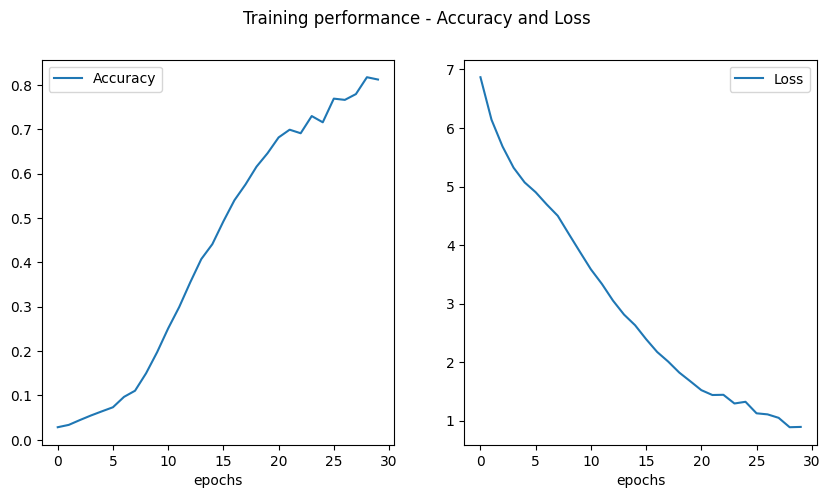

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance - Accuracy and Loss')
for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')